# 1- EDA % Visualize

OTIF Inbound (Qty): 0.46
OTIF Outbound (Qty): 0.39
Scrap Rate %: 2.49
Total Downtime Hours: 110.0


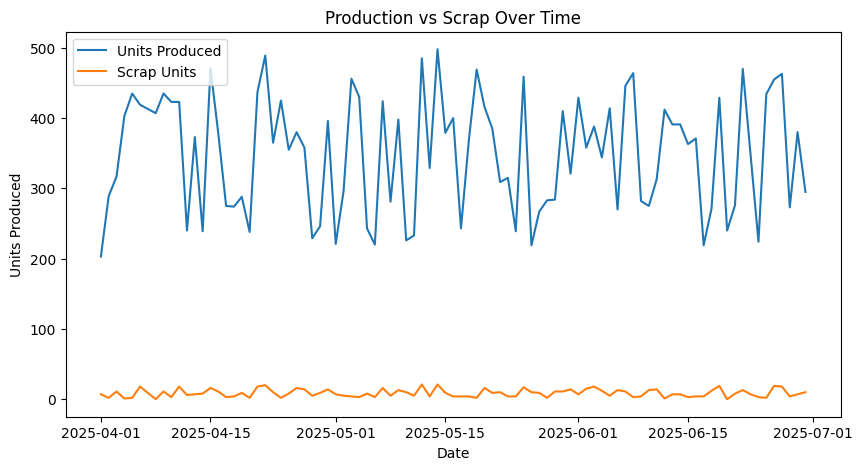

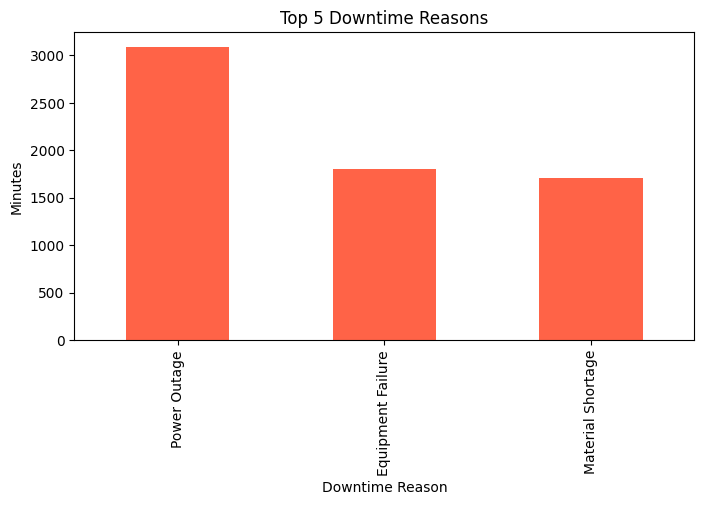

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

inbound = pd.read_csv("E:\Data_analysis\Aira Project\Dataset\inbound-deliveries.csv")
outbound = pd.read_csv("E:\Data_analysis\Aira Project\Dataset\outbound-shipments.csv")
prod = pd.read_csv("E:\Data_analysis\Aira Project\Dataset\production-output.csv")
loss = pd.read_csv("E:\Data_analysis\Aira Project\Dataset\loss-hierarchy.csv")


for df, col in [(inbound, "Planned Delivery Date"), (inbound, "Actual Delivery Date"),
                (outbound, "Planned Ship Date"), (outbound, "Actual Ship Date"),
                (prod, "Date")]:
    df[col] = pd.to_datetime(df[col], errors='coerce')
    

inbound['OnTimeFlag'] = inbound['Actual Delivery Date'] <= inbound['Planned Delivery Date']
otif_inbound_qty = inbound.loc[inbound['OnTimeFlag'], 'Quantity'].sum() / inbound['Quantity'].sum()


outbound['OnTimeFlag'] = outbound['Actual Ship Date'] <= outbound['Planned Ship Date']
otif_outbound_qty = outbound.loc[outbound['OnTimeFlag'], 'Quantity'].sum() / outbound['Quantity'].sum()


scrap_rate = prod['Scrap Units'].sum() / prod['Units Produced'].sum()


total_downtime_hours = prod['Downtime Minutes'].sum() / 60

print("OTIF Inbound (Qty):", round(otif_inbound_qty, 2))
print("OTIF Outbound (Qty):", round(otif_outbound_qty, 2))
print("Scrap Rate %:", round(scrap_rate*100, 2))
print("Total Downtime Hours:", round(total_downtime_hours, 2))


plt.figure(figsize=(10,5))
sns.lineplot(data=prod, x='Date', y='Units Produced', label='Units Produced')
sns.lineplot(data=prod, x='Date', y='Scrap Units', label='Scrap Units')
plt.title("Production vs Scrap Over Time")
plt.legend()
plt.show()


top_downtime = prod.groupby('Downtime Reason')['Downtime Minutes'].sum().sort_values(ascending=False).head(5)
top_downtime.plot(kind='bar', figsize=(8,4), color='tomato')
plt.title("Top 5 Downtime Reasons")
plt.ylabel("Minutes")
plt.show()


In [2]:
import pandas as pd



prod.columns = prod.columns.str.strip()
loss.columns = loss.columns.str.strip()


prod["Downtime Hours"] = pd.to_numeric(prod["Downtime Minutes"], errors="coerce") / 60.0


merged = prod.merge(loss, left_on="Downtime Reason", right_on="Level 3", how="left")


agg_L1 = merged.groupby("Level 1", dropna=False)["Downtime Hours"].sum().reset_index().sort_values("Downtime Hours", ascending=False)
top3_L1 = agg_L1.head(3)


agg_L2 = merged.groupby(["Level 1", "Level 2"], dropna=False)["Downtime Hours"].sum().reset_index().sort_values("Downtime Hours", ascending=False)
top3_L2 = agg_L2.head(3)

print("Top 3 Loss Categories (Level 1):")
print(top3_L1)

print("\nTop 3 Loss Categories (Level 2):")
print(top3_L2)


Top 3 Loss Categories (Level 1):
   Level 1  Downtime Hours
0      NaN           110.0

Top 3 Loss Categories (Level 2):
   Level 1  Level 2  Downtime Hours
0      NaN      NaN           110.0


# 2- ML Model Classification

In [3]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import joblib


df = pd.read_csv("E:\Data_analysis\Aira Project\Dataset\outbound-shipments.csv", 
                 parse_dates=["Planned Ship Date", "Actual Ship Date"])


df = df.rename(columns=lambda c: c.strip())
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce").fillna(0)

print(f"Dataset size: {len(df)} rows")


df["OnTime"] = np.where(
    df["Actual Ship Date"].notna() &
    df["Planned Ship Date"].notna() &
    (df["Actual Ship Date"] <= df["Planned Ship Date"]), 1, 0
)


print(f"Target distribution:\n{df['OnTime'].value_counts()}")
print(f"On-time percentage: {df['OnTime'].mean():.2%}")


df["PlannedWeekday"] = df["Planned Ship Date"].dt.dayofweek
df["PlannedMonth"] = df["Planned Ship Date"].dt.month
df["PlannedQuarter"] = df["Planned Ship Date"].dt.quarter


df["DaysFromToday"] = (df["Planned Ship Date"] - pd.Timestamp.now()).dt.days
df["IsWeekend"] = df["PlannedWeekday"].isin([5, 6]).astype(int)
df["QuantityCategory"] = pd.cut(df["Quantity"], bins=[0, 10, 50, 100, float('inf')], 
                               labels=['Small', 'Medium', 'Large', 'XLarge'])


df = df.dropna(subset=["Planned Ship Date"])
df = df[df["Actual Ship Date"].notna()]  


cat_features = ["Customer", "Product", "QuantityCategory"]  
num_features = ["Quantity", "PlannedWeekday", "PlannedMonth", "PlannedQuarter", 
                "DaysFromToday", "IsWeekend"]


print(f"Available data after cleaning: {len(df)} rows")
if len(df) < 100:
    print("WARNING: Very small dataset - results may not be reliable!")

X = df[cat_features + num_features]
y = df["OnTime"]


X = X.copy()  
for col in cat_features:
    if X[col].dtype.name == 'category':
        
        X[col] = X[col].cat.add_categories("Unknown").fillna("Unknown")
    else:
       
        X[col] = X[col].fillna("Unknown")


test_size = 0.3 if len(df) > 200 else 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)}, Test set: {len(X_test)}")


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features),
        ("num", StandardScaler(), num_features)
    ]
)


clf = Pipeline([
    ("pre", preprocessor),
    ("rf", RandomForestClassifier(
        n_estimators=100,  
        max_depth=10,      
        min_samples_split=10,  
        min_samples_leaf=5,    
        max_features='sqrt',   
        random_state=42, 
        n_jobs=-1
    ))
])


cv_scores = cross_val_score(clf, X_train, y_train, cv=StratifiedKFold(5), 
                           scoring='roc_auc', n_jobs=-1)
print(f"Cross-validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


clf.fit(X_train, y_train)


y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_test_proba = clf.predict_proba(X_test)[:, 1]


train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\nTRAINING Accuracy: {train_acc:.4f}")
print(f"TEST Accuracy: {test_acc:.4f}")
print(f"Accuracy difference: {abs(train_acc - test_acc):.4f}")

if abs(train_acc - test_acc) > 0.1:
    print("WARNING: Large gap between training and test accuracy suggests overfitting!")


print("\nTest Set Classification Report:")
print(classification_report(y_test, y_test_pred))


test_auc = roc_auc_score(y_test, y_test_proba)
print(f"Test ROC AUC: {test_auc:.4f}")


cm = confusion_matrix(y_test, y_test_pred)
print("Test Confusion matrix:\n", cm)


try:

    cat_ohe = clf.named_steps["pre"].named_transformers_["cat"]
    ohe_cols = list(cat_ohe.get_feature_names_out(cat_features))
    feature_names = ohe_cols + num_features
    
    importances = clf.named_steps["rf"].feature_importances_
    feat_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False).head(15)
    
    print("\nTop Feature Importances:")
    print(feat_imp)
except Exception as e:
    print(f"Error getting feature importances: {e}")


print(f"\nDataset diagnostics:")
print(f"- Total samples: {len(df)}")
print(f"- Features used: {len(cat_features + num_features)}")
print(f"- Categorical features: {cat_features}")
print(f"- Numerical features: {num_features}")


if test_auc < 0.95:  
    joblib.dump(clf, "otif_outbound_rf_model_v2.pkl")
    print("Saved model to otif_outbound_rf_model_v2.pkl")
else:
    print("Model performance too perfect - not saving (likely overfitting)")

Dataset size: 250 rows
Target distribution:
OnTime
0    150
1    100
Name: count, dtype: int64
On-time percentage: 40.00%
Available data after cleaning: 250 rows
Training set: 175, Test set: 75
Cross-validation ROC AUC: 0.4660 (+/- 0.2656)

TRAINING Accuracy: 0.7771
TEST Accuracy: 0.6000
Accuracy difference: 0.1771

Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.82      0.71        45
           1       0.50      0.27      0.35        30

    accuracy                           0.60        75
   macro avg       0.56      0.54      0.53        75
weighted avg       0.58      0.60      0.57        75

Test ROC AUC: 0.4748
Test Confusion matrix:
 [[37  8]
 [22  8]]

Top Feature Importances:
                    feature  importance
15            DaysFromToday    0.232275
11                 Quantity    0.211482
12           PlannedWeekday    0.136421
8        Product_Thermostat    0.071151
13             PlannedMonth    0.

In [4]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
import joblib
import warnings
warnings.filterwarnings('ignore')


df = pd.read_csv("E:\Data_analysis\Aira Project\Dataset\outbound-shipments.csv", 
                 parse_dates=["Planned Ship Date", "Actual Ship Date"])


df = df.rename(columns=lambda c: c.strip())
df["Quantity"] = pd.to_numeric(df["Quantity"], errors="coerce").fillna(0)

print(f"Dataset size: {len(df)} rows")


df["OnTime"] = np.where(
    df["Actual Ship Date"].notna() &
    df["Planned Ship Date"].notna() &
    (df["Actual Ship Date"] <= df["Planned Ship Date"]), 1, 0
)


print(f"Target distribution:\n{df['OnTime'].value_counts()}")
print(f"On-time percentage: {df['OnTime'].mean():.2%}")


df = df.dropna(subset=["Planned Ship Date"])
df = df[df["Actual Ship Date"].notna()]


df["PlannedWeekday"] = df["Planned Ship Date"].dt.dayofweek
df["PlannedMonth"] = df["Planned Ship Date"].dt.month
df["PlannedQuarter"] = df["Planned Ship Date"].dt.quarter
df["PlannedYear"] = df["Planned Ship Date"].dt.year
df["IsWeekend"] = df["PlannedWeekday"].isin([5, 6]).astype(int)
df["IsMonthEnd"] = df["Planned Ship Date"].dt.is_month_end.astype(int)
df["IsYearEnd"] = df["Planned Ship Date"].dt.is_year_end.astype(int)


df["LogQuantity"] = np.log1p(df["Quantity"])
df["QuantityGroup"] = pd.qcut(df["Quantity"], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')


customer_ontime_rate = df.groupby("Customer")["OnTime"].mean()
product_ontime_rate = df.groupby("Product")["OnTime"].mean()

df["CustomerOntimeRate"] = df["Customer"].map(customer_ontime_rate)
df["ProductOntimeRate"] = df["Product"].map(product_ontime_rate)


customer_volume = df.groupby("Customer")["Quantity"].mean()
product_volume = df.groupby("Product")["Quantity"].mean()

df["CustomerAvgVolume"] = df["Customer"].map(customer_volume)
df["ProductAvgVolume"] = df["Product"].map(product_volume)

print(f"Available data after feature engineering: {len(df)} rows")


num_features = [
    "Quantity", "LogQuantity", "PlannedWeekday", "PlannedMonth", "PlannedQuarter",
    "IsWeekend", "IsMonthEnd", "IsYearEnd", "CustomerOntimeRate", "ProductOntimeRate",
    "CustomerAvgVolume", "ProductAvgVolume"
]

cat_features = ["QuantityGroup"]  


X = df[num_features + cat_features].copy()
y = df["OnTime"]


for col in num_features:
    X[col] = X[col].fillna(X[col].median())

for col in cat_features:
    if X[col].dtype.name == 'category':
        X[col] = X[col].cat.add_categories("Unknown").fillna("Unknown")
    else:
        X[col] = X[col].fillna("Unknown")


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)}, Test set: {len(X_test)}")


preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_features)
    ]
)


models = {
    "Logistic Regression": Pipeline([
        ("pre", preprocessor),
        ("lr", LogisticRegression(random_state=42, max_iter=1000))
    ]),
    
    "Random Forest (Conservative)": Pipeline([
        ("pre", preprocessor),
        ("rf", RandomForestClassifier(
            n_estimators=50,
            max_depth=5,
            min_samples_split=20,
            min_samples_leaf=10,
            max_features='sqrt',
            random_state=42
        ))
    ]),
    
    "Random Forest (Balanced)": Pipeline([
        ("pre", preprocessor),
        ("rf", RandomForestClassifier(
            n_estimators=100,
            max_depth=8,
            min_samples_split=15,
            min_samples_leaf=8,
            max_features=0.7,
            random_state=42,
            class_weight='balanced'  
        ))
    ])
}


best_model = None
best_score = 0
results = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Model: {name}")
    print(f"{'='*50}")
    
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=StratifiedKFold(5), 
                               scoring='roc_auc', n_jobs=-1)
    
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:, 1]
    
    
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_proba)
    
    print(f"Cross-validation ROC AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test ROC AUC: {test_auc:.4f}")
    print(f"Overfitting gap: {abs(train_acc - test_acc):.4f}")
    
    if abs(train_acc - test_acc) > 0.15:
        print("⚠️  High overfitting detected!")
    
    if test_auc > 0.5:
        print("✅ Better than random!")
    else:
        print("❌ Worse than random")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    
    
    results[name] = {
        'cv_auc': cv_scores.mean(),
        'test_auc': test_auc,
        'test_acc': test_acc,
        'overfitting': abs(train_acc - test_acc)
    }
    
    
    if test_auc > best_score and abs(train_acc - test_acc) < 0.2:
        best_score = test_auc
        best_model = (name, model)


print(f"\n{'='*60}")
print("SUMMARY OF ALL MODELS")
print(f"{'='*60}")

for name, metrics in results.items():
    print(f"{name:25} | AUC: {metrics['test_auc']:.3f} | "
          f"Acc: {metrics['test_acc']:.3f} | Overfit: {metrics['overfitting']:.3f}")

if best_model:
    print(f"\n🏆 Best Model: {best_model[0]} (AUC: {best_score:.3f})")
    
    
    if hasattr(best_model[1].named_steps.get('rf'), 'feature_importances_'):
        try:
            
            if 'cat' in best_model[1].named_steps["pre"].named_transformers_:
                cat_ohe = best_model[1].named_steps["pre"].named_transformers_["cat"]
                ohe_cols = list(cat_ohe.get_feature_names_out(cat_features))
                feature_names = num_features + ohe_cols
            else:
                feature_names = num_features
            
            importances = best_model[1].named_steps['rf'].feature_importances_
            feat_imp = pd.DataFrame({
                "feature": feature_names,
                "importance": importances
            }).sort_values("importance", ascending=False).head(10)
            
            print(f"\nTop 10 Feature Importances ({best_model[0]}):")
            print(feat_imp)
            
        except Exception as e:
            print(f"Could not extract feature importances: {e}")
    
    
    joblib.dump(best_model[1], "best_otif_model.pkl")
    print(f"\nSaved best model to best_otif_model.pkl")
else:
    print("\n❌ No model performed better than random!")


print(f"\n{'='*60}")
print("RECOMMENDATIONS")
print(f"{'='*60}")

if best_score < 0.6:
    print("📊 Model performance is still weak. Consider:")
    print("   • Collecting more data")
    print("   • Adding external features (weather, holidays, etc.)")
    print("   • Different problem formulation (regression instead of classification)")
    print("   • Time series approach")

if any(r['overfitting'] > 0.15 for r in results.values()):
    print("🎯 Overfitting detected. Consider:")
    print("   • More regularization")
    print("   • Simpler models")
    print("   • More training data")

print("✨ Next steps:")
print("   • Analyze misclassified cases")
print("   • Feature selection/engineering")
print("   • Ensemble methods")
print("   • Hyperparameter tuning")

Dataset size: 250 rows
Target distribution:
OnTime
0    150
1    100
Name: count, dtype: int64
On-time percentage: 40.00%
Available data after feature engineering: 250 rows
Training set: 175, Test set: 75

Model: Logistic Regression
Cross-validation ROC AUC: 0.5333 (+/- 0.1534)
Training Accuracy: 0.6914
Test Accuracy: 0.6267
Test ROC AUC: 0.5193
Overfitting gap: 0.0648
✅ Better than random!

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.76      0.71        45
           1       0.54      0.43      0.48        30

    accuracy                           0.63        75
   macro avg       0.60      0.59      0.59        75
weighted avg       0.62      0.63      0.62        75


Model: Random Forest (Conservative)
Cross-validation ROC AUC: 0.4571 (+/- 0.2246)
Training Accuracy: 0.6857
Test Accuracy: 0.6133
Test ROC AUC: 0.4281
Overfitting gap: 0.0724
❌ Worse than random

Classification Report:
              precision    recall  